Mandatory imports:

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint`a


Copy-paste of the previous pre-processing. Actually this time I added the intra-day timestamps (the time of the day) in the data.

In [14]:
f = open("../data/awanode-farmlab-2017-09-07.txt")
data=[]
times = list()
prevt=0
linei=0
for l in f.read().split('\n'):
    a=l.replace("|"," ").replace("="," ").replace(";"," ").split(" ")
    if len(a)>11:
        tim = [int(num) for num in a[1].split(':')]
        curt = tim[2]+tim[1]*60+tim[0]*3600
        if curt-prevt>1000:
            data.append((a[2],a[4],a[6],a[8],a[10],a[12], linei, a[1]))
        prevt = curt
    linei+=1

Let's check the look of the data so far:

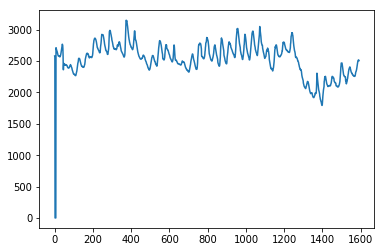

In [15]:
ytemp = [int(row[1]) for row in data]
plt.plot(range(len(ytemp)), ytemp)
plt.show()

Looks good, expect for a bunch of zeros at the beginning. Let's select the dww (data we want) by pruning the data at the beginning.

In [22]:
dww=data[8:]

To plot it, I made a function that will make it easier to replot different data:

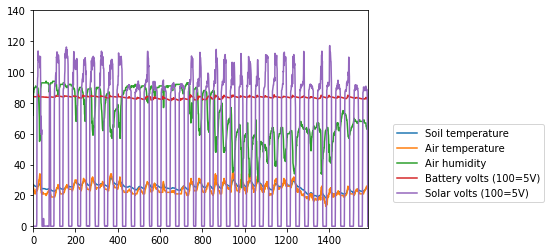

In [24]:
def make_graph(dd):
    x = range(len(dd))
    temp_soil = [float(row[1])/100.0 for row in dd]
    temp_air = [float(row[2]) for row in dd]
    hum = [float(row[3]) for row in dd]
    vbat = [float(row[4])/50.0 for row in dd]
    vsol = [float(row[5])/50.0 for row in dd]


    xmin=0
    xmax=len(x)
    ymin = -1
    ymax= 140
    plt.plot(x, temp_soil, label="Soil temperature")
    plt.plot(x, temp_air, label="Air temperature")
    plt.plot(x, hum, label="Air humidity")
    plt.plot(x, vbat, label="Battery volts (100=5V)")
    plt.plot(x, vsol, label="Solar volts (100=5V)")
    plt.legend(loc='upper center', bbox_to_anchor=(1.3, 0.5))
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])
    plt.show()

make_graph(dww)

It starts being a bit crampled. I'd like to abstract the day variations. Let's see if I get good results by taking a single timestamp per day.


In [38]:
# creates a function that converts timestamps (strings) into a number of seconds since midnight
def to_seconds(timestamp):
    h,m,s = timestamp.split(":")
    return int(h)*3600+int(m)*60+int(s)

# Calculate the number of seconds at 1PM
threshold = to_seconds("13:00:00")

# Create newdata by adding the first data after 1 PM for each day
newdata=list()
morning = True
for d in dww:
    seconds = to_seconds(d[7])
    if morning and seconds>threshold:
        morning=False
        newdata.append(d)
    if seconds<threshold:
        morning=True


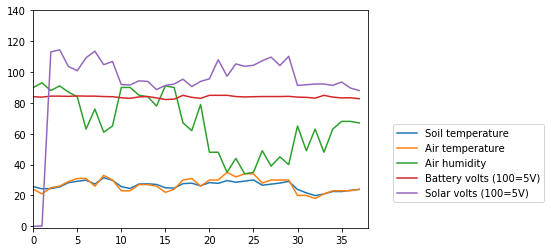

In [29]:
make_graph(newdata)

Clearer but still a bit noisy. Let's make the average over the 5 data points after 1 PM instead:

In [52]:
newdata=list()
morning = True
sum=0
count=5
for d in dww:
    seconds = to_seconds(d[7])
    if seconds>threshold and count>0:
        morning=False
        count = count-1
        newdata.append(d)
    if seconds<threshold:
        morning=True
        sum=0
        count=5

newdata2=list()
for i in range(0,len(newdata)-5, 5):
    sums = [0]*len(d)
    for j in range(0,5):
        for k in range(0,len(newdata[i+j])-1):
            sums[k]+=float(newdata[i+j][k])
    for k in range(0,len(sums)):
        sums[k] = sums[k]/5.0
    newdata2.append(sums)


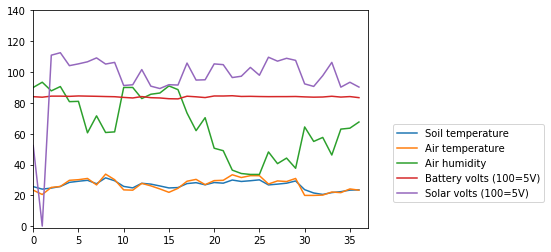

In [53]:
make_graph(newdata2)

Not a huge difference